# Use MARS to predict execution time based on mini-batch size
## Make separate models for each platform

In [118]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess, os
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from pyearth import Earth

In [4]:
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
remove_str="[J"


# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global batch_learn_pattern
    global output_pattern
    global remove_str
    logfile = logfile.strip(" \n")
    with open(logfile,"r") as f:
        lines = f.readlines()
        batch = 0
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            s = s.replace(remove_str,"")
            m = batch_learn_pattern.match(s)
            if m:
                batch = int(m.group(1))
                learn = float(m.group(2))
                if debug: print logfile,": b",batch," l",learn
            else:
                m2 = output_pattern.match(s)
                if m2:
                    epoch = int(m2.group(1))
                    time = float(m2.group(6))
                    if debug: print batch,learn,epoch,time
                    df.loc[ind] = [batch,learn,epoch,time]
                    ind += 1
                    
    return df

In [5]:
filename_pattern=re.compile(r"cifar_.*\.log")

def readLogs(logdir, debug=False):
    global filename_pattern
    list_command = "ls -1 "+logdir
    if debug: print "Looking in",logdir
    files=[]
    proc = subprocess.Popen(list_command.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    if debug: print len(files),"files"
    df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])

    for file in files:
        df1 = fileToDF(file,debug)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
    return df

In [6]:
!ls logs/microseries/

GTX_TITAN_X K80         QuadroP2000


In [39]:
df_mouse=readLogs("logs/microseries/QuadroP2000")
df_DLsrv=readLogs("logs/microseries/GTX_TITAN_X")
df_mouse.head()

,batch,learn,epoch,time
0,101.0,0.15,1.0,90.3823
1,101.0,0.15,1.0,90.4984
2,102.0,0.15,1.0,90.1218
3,103.0,0.15,1.0,90.1364
4,104.0,0.15,1.0,90.1099


In [40]:
def readLogsK80(logdir, debug=False):
    global filename_pattern    
    
    list_command = "ls -1 "+logdir
    files=[]
    proc = subprocess.Popen(list_command.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    if debug: maxfiles = 5
    else: maxfiles = 100000000
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])

    filecounter=0
    for file in files:
        if debug: print file
        df1 = fileToDF_K80(file,debug)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return df

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF_K80(logfile, debug=False):
    batch_learn_pattern = "_b(\d+)_l([0-9\.]+)"
    global output_pattern
    remove_str = ["[4A","[J"]
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    m = re.search(batch_learn_pattern, filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        if debug: print "BS,LR:",batch,learn

    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            for rmstr in remove_str:
                s = s.replace(rmstr,"")            
            m2 = output_pattern.match(s)
            if m2:
                if debug: print s,
                epoch = int(m2.group(1))
                time = float(m2.group(6))
                if debug: print "BS,LR,epoch,time:",batch,learn,epoch,time
                df.loc[ind] = [batch,learn,epoch,time]
                ind += 1
                    
    return df

In [41]:
df_K80=readLogsK80("logs/microseries/K80")
df_K80.describe()

,batch,learn,epoch,time
count,266.000000,2.660000e+02,266.0,266.000000
mean,466.210526,1.500000e-01,1.0,169.938150
std,244.284911,2.780790e-17,0.0,17.175434
min,65.000000,1.500000e-01,1.0,87.221800
25%,246.000000,1.500000e-01,1.0,172.636000
50%,453.500000,1.500000e-01,1.0,173.322500
75%,683.000000,1.500000e-01,1.0,174.097500
max,895.000000,1.500000e-01,1.0,181.592000


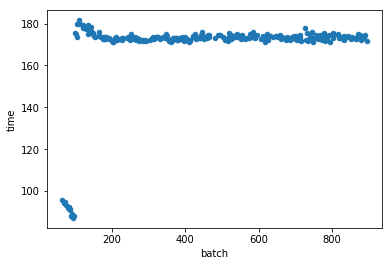

In [42]:
df_K80.plot(kind="scatter",x="batch",y="time")

In [11]:
print df_DLsrv.shape
print df_mouse.shape
print df_K80.shape

(961, 4)
(800, 4)
(266, 4)


## Prepare samples X and GT Y

In [12]:
print df_DLsrv.describe()
df_DLsrv.head()

             batch         learn  epoch        time
count   961.000000  9.610000e+02  961.0  961.000000
mean    544.000000  1.500000e-01    1.0   25.553726
std     277.561104  2.777003e-17    0.0    1.548097
min      64.000000  1.500000e-01    1.0   23.696200
25%     304.000000  1.500000e-01    1.0   24.645000
50%     544.000000  1.500000e-01    1.0   25.076300
75%     784.000000  1.500000e-01    1.0   25.847200
max    1024.000000  1.500000e-01    1.0   33.427900


,batch,learn,epoch,time
0,1000.0,0.15,1.0,24.4252
1,1001.0,0.15,1.0,24.4108
2,1002.0,0.15,1.0,24.4341
3,1003.0,0.15,1.0,24.7236
4,1004.0,0.15,1.0,25.0943


## DL server

In [13]:
features = ['batch']
X = df_DLsrv[features].values
Y = df_DLsrv["time"].values
print X.shape

(961, 1)


### Split samples to training and test sets

(10, 1) x (951, 1)


/Users/peterbryzgalov/Library/Python/2.7/lib/python/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


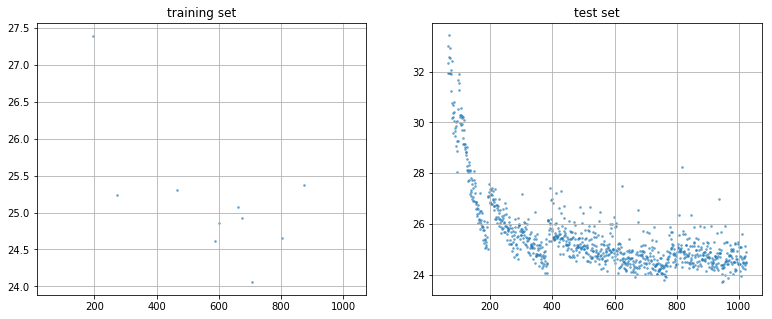

In [14]:
# Create training and test sets.
train_size=10
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, shuffle = True)

print X_train.shape,"x",X_test.shape
f, axarr = plt.subplots(1,2, sharex=True,figsize=(13,5))
sc0 = axarr[0].scatter(x=X_train,y=Y_train,s=3,alpha=0.5,cmap="rainbow")
sc1 = axarr[1].scatter(x=X_test,y=Y_test,s=3,alpha=0.5,cmap="rainbow")
axarr[0].set_title("training set")
axarr[1].set_title("test set")
axarr[0].grid()
axarr[1].grid()

plt.show()

In [15]:
np.random.seed(0)
model = Earth(max_degree=4,max_terms=300)
model.fit(X_train,Y_train)
H_train = model.predict(X_train)
MSE_train = mean_squared_error(Y_train, H_train)
print "MSE_train=",MSE_train
H_test = model.predict(X_test)
MSE_test = mean_squared_error(Y_test, H_test)
print "MSE_test=",MSE_test

MSE_train= 0.0724357899717
MSE_test= 5.14398627272


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


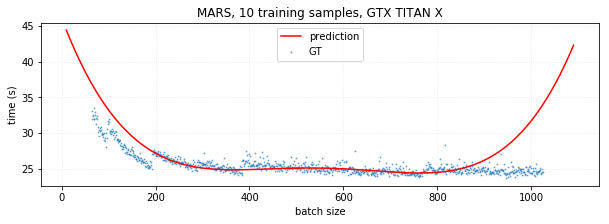

In [16]:
# Plot prediction line
def plotPredictions(df, model,title):
    X = df['batch'].values
    Y = df["time"].values
    x_ = np.arange(10,1100,10)
    fig,ax = plt.subplots(figsize=(10,3))
    ax.set_title(title)
    h = model.predict(x_)
    ax.plot(x_,h,c="r",label="prediction")
    ax.scatter(X,Y,s=1,alpha=.5,label="GT")
    ax.set_ylabel("time (s)")
    ax.grid(ls=":",alpha=0.3)
    ax.legend()
    ax.set_xlabel("batch size")
    fig.show()

plotPredictions(df_DLsrv,model,"MARS, "+str(train_size)+" training samples, GTX TITAN X")

## Mouse

### Prepare dataset

(800, 1)
(10, 1) x (790, 1)


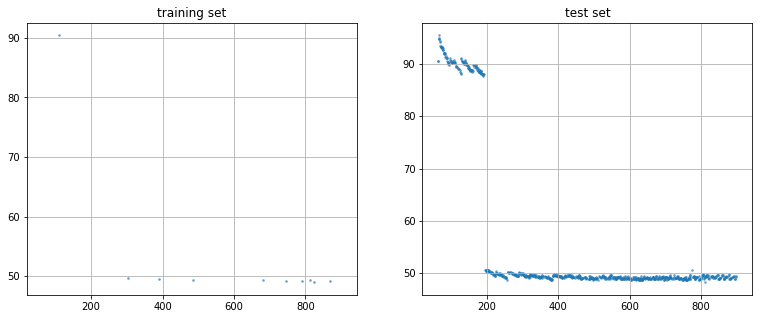

In [17]:
def prepareDataset(df):
    features = ["batch"]
    X = df[features].values
    Y = df["time"].values
    print X.shape
    # Create training and test sets.
    train_size=10
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, shuffle = True)

    print X_train.shape,"x",X_test.shape
    f, axarr = plt.subplots(1,2, sharex=True,figsize=(13,5))
    sc0 = axarr[0].scatter(x=X_train,y=Y_train,s=3,alpha=0.5,cmap="rainbow")
    sc1 = axarr[1].scatter(x=X_test,y=Y_test,s=3,alpha=0.5,cmap="rainbow")
    axarr[0].set_title("training set")
    axarr[1].set_title("test set")
    axarr[0].grid()
    axarr[1].grid()
    plt.show()
    return (X_train,X_test,Y_train,Y_test)

X_train,X_test,Y_train,Y_test = prepareDataset(df_mouse)

MSE_train= 0.00798266250629
MSE_test= 31.5216225853


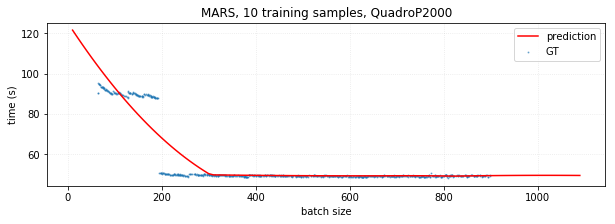

In [18]:
model = Earth(max_degree=2,max_terms=500,endspan=1)
model.fit(X_train,Y_train)
H_train = model.predict(X_train)
MSE_train = mean_squared_error(Y_train, H_train)
print "MSE_train=",MSE_train
H_test = model.predict(X_test)
MSE_test = mean_squared_error(Y_test, H_test)
print "MSE_test=",MSE_test
plotPredictions(df_mouse,model,"MARS, "+str(train_size)+" training samples, QuadroP2000")

# K80

(266, 1)
(10, 1) x (256, 1)


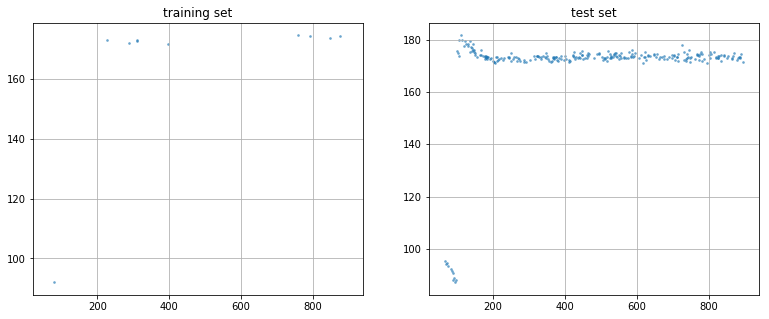

In [25]:
def prepareDataset(df):
    features = ["batch"]
    X = df[features].values
    Y = df["time"].values
    print X.shape
    # Create training and test sets.
    train_size=10
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, shuffle = True)

    print X_train.shape,"x",X_test.shape
    f, axarr = plt.subplots(1,2, sharex=True,figsize=(13,5))
    sc0 = axarr[0].scatter(x=X_train,y=Y_train,s=3,alpha=0.5,cmap="rainbow")
    sc1 = axarr[1].scatter(x=X_test,y=Y_test,s=3,alpha=0.5,cmap="rainbow")
    axarr[0].set_title("training set")
    axarr[1].set_title("test set")
    axarr[0].grid()
    axarr[1].grid()
    plt.show()
    return (X_train,X_test,Y_train,Y_test)

X_train,X_test,Y_train,Y_test = prepareDataset(df_K80)

MSE_train= 0.279958238094
MSE_test= 238.142740594


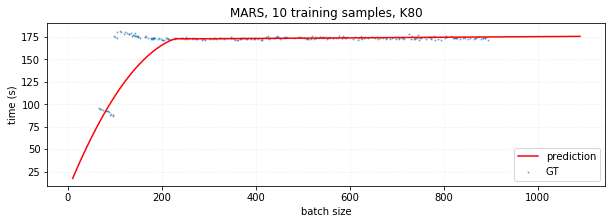

In [36]:
model = Earth(max_degree=2,endspan=1)
model.fit(X_train,Y_train)
H_train = model.predict(X_train)
MSE_train = mean_squared_error(Y_train, H_train)
print "MSE_train=",MSE_train
H_test = model.predict(X_test)
MSE_test = mean_squared_error(Y_test, H_test)
print "MSE_test=",MSE_test
plotPredictions(df_K80,model,"MARS, "+str(train_size)+" training samples, K80")

## Merge platforms

In [43]:
df_DLsrv_t = df_DLsrv.copy()
df_mouse_t = df_mouse.copy()
df_K80_t = df_K80.copy()
df_DLsrv_t["GPU"] = "GTX TITAN X" # Single precision peak GFLOPS for GTX TITAN X
df_mouse_t["GPU"] = "QuadroP2000"
df_K80_t["GPU"] = "K80"
df_DLsrv_t.drop(["learn","epoch"],axis=1,inplace=True)
df_mouse_t.drop(["learn","epoch"],axis=1,inplace=True)
df_K80_t.drop(["learn","epoch"],axis=1,inplace=True)
mdf = pd.concat([df_DLsrv_t,df_mouse_t,df_K80_t],ignore_index=True)
print mdf.shape
mdf.head()

(2027, 3)


,batch,time,GPU
0,1000.0,24.4252,GTX TITAN X
1,1001.0,24.4108,GTX TITAN X
2,1002.0,24.4341,GTX TITAN X
3,1003.0,24.7236,GTX TITAN X
4,1004.0,25.0943,GTX TITAN X


In [44]:
!ls .. | grep "GPU"

GPU_data.csv


In [45]:
GPU_df = pd.read_csv("../GPU_data.csv")
GPU_df.rename({"GPU model":"GPU"},axis=1,inplace=True)
GPU_df.head()

,GPU,CUDA cap,CUDA cores,Boost clock (GHz),Memory size (GB),Memory bandwidth (GB/s),SP (GFLOPS),DP (GFLOPS),L2 size (MB)
0,GTX TITAN X,5.2,3072,1.075,12.207,336.00,6144,192.0,3.145728
1,QuadroP2000,6.1,1024,1.480,5.053,140.00,3000,94.7,1.310720
2,K80,3.7,2496,0.875,12.000,240.48,8736,2912.0,1.572864


In [46]:
# SQL-like join
df = pd.merge(mdf,GPU_df,on="GPU")
df[df["GPU"]=="K80"].head()

,batch,time,GPU,CUDA cap,CUDA cores,Boost clock (GHz),Memory size (GB),Memory bandwidth (GB/s),SP (GFLOPS),DP (GFLOPS),L2 size (MB)
1761,101.0,174.921,K80,3.7,2496,0.875,12.0,240.48,8736,2912.0,1.572864
1762,104.0,173.678,K80,3.7,2496,0.875,12.0,240.48,8736,2912.0,1.572864
1763,105.0,179.941,K80,3.7,2496,0.875,12.0,240.48,8736,2912.0,1.572864
1764,110.0,181.592,K80,3.7,2496,0.875,12.0,240.48,8736,2912.0,1.572864
1765,112.0,179.857,K80,3.7,2496,0.875,12.0,240.48,8736,2912.0,1.572864


## Prepare samples X and GT Y

In [47]:
GPU_df.columns.values

array(['GPU', 'CUDA cap', 'CUDA cores', 'Boost clock (GHz)',
       'Memory size (GB)', 'Memory bandwidth (GB/s)', 'SP (GFLOPS)',
       'DP (GFLOPS)', 'L2 size (MB)'], dtype=object)

In [49]:
features = ['batch', 'CUDA cap', 'CUDA cores', 'Boost clock (GHz)',  'Memory size (GB)', 'Memory bandwidth (GB/s)', 'SP (GFLOPS)',
       'DP (GFLOPS)', 'L2 size (MB)']
X = df[features].values
Y = df["time"].values
X.shape

(2027, 9)

### Split samples to training and test sets

In [151]:
# Create training and test sets.
train_size=300
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, train_size=train_size, shuffle = True)

print X_train.shape,"x",X_test.shape

(300, 9) x (1727, 9)


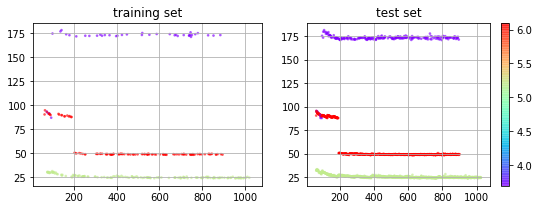

In [152]:
f, axarr = plt.subplots(1,2, sharex=True,figsize=(9,3))
sc0 = axarr[0].scatter(x=X_train[:,0],y=Y_train,c=X_train[:,1],s=3,alpha=0.5,cmap="rainbow")
sc1 = axarr[1].scatter(x=X_test[:,0],y=Y_test,c=X_test[:,1],s=3,alpha=0.5,cmap="rainbow")
axarr[0].set_title("training set")
axarr[1].set_title("test set")
axarr[0].grid()
axarr[1].grid()

plt.colorbar(sc1,ax=axarr[1])
plt.show()

In [153]:
model = Earth(max_degree=2,max_terms=500,endspan=1,penalty=5)
model.fit(X_train,Y_train)
print X_train.shape

(300, 9)


In [154]:
H_test = model.predict(X_test)
MSE_test = mean_squared_error(Y_test, H_test)
print "MST_test=",MSE_test
H_train = model.predict(X_train)
mean_squared_error(Y_train, H_train)

MST_test= 14.0282140916


18.750759230711033

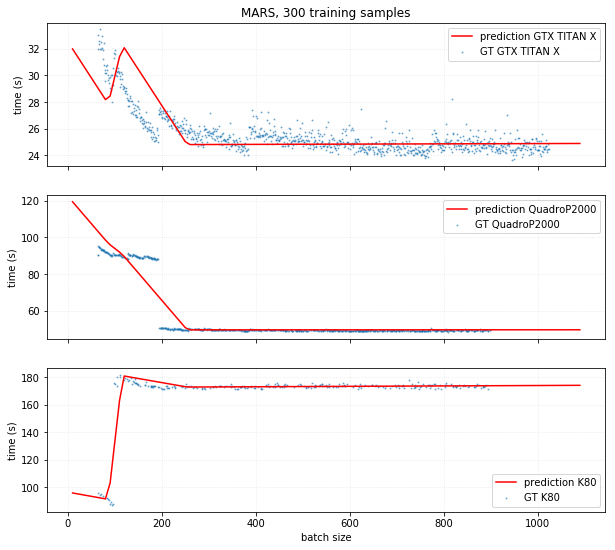

In [155]:
# Plot prediction line
def plotPredictions(model,title):
    columns=['batch', 'CUDA cap', 'CUDA cores', 'Boost clock (GHz)',  'Memory size (GB)', 'Memory bandwidth (GB/s)', 'SP (GFLOPS)',
           'DP (GFLOPS)', 'L2 size (MB)']
    df_tmp = pd.DataFrame(columns=columns)                     
    x_ = np.arange(10,1100,10)
    architectures = df["CUDA cap"].unique()
    fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,9))
    ax[0].set_title(title)
    for i in range(len(architectures)):
        CUDA_cap = architectures[i]
        GPU = df[df["CUDA cap"]==CUDA_cap]["GPU"].iloc[0]
        add = df[df["CUDA cap"]==CUDA_cap][columns[1:]].iloc[0].values
        for j in range(len(x_)):
            df_tmp.loc[j] = np.insert(add,0,x_[j])

        y_ = model.predict(df_tmp)
        
        ax[i].plot(x_,y_,c="r",label="prediction "+GPU)
        ax[i].scatter(df[df["CUDA cap"]==CUDA_cap]["batch"].values,
                   df[df["CUDA cap"]==CUDA_cap]["time"].values,s=1,alpha=.5,label="GT "+GPU)


        ax[i].set_ylabel("time (s)")
        ax[i].grid(ls=":",alpha=0.3)
        ax[i].legend()
    ax[-1].set_xlabel("batch size")
    fig.show()

plotPredictions(model,"MARS, "+str(train_size)+" training samples")

## Hyperparameter Search

In [157]:
model = Earth()
#model.fit(X_train,Y_train)
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
# specify parameters and distributions to sample from
param_dist = {"max_terms": [None,100, 500, 1000],
              "max_degree": [None, 2, 3, 4],
              "penalty": sp_randint(1, 50),
              "endspan": [None,1,2,3,4,5]} 

mse = make_scorer(mean_squared_error, greater_is_better=False)

# run randomized search
n_iter_search = 300
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter_search, scoring=mse)

start = time()
random_search.fit(X, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 104.63 seconds for 300 candidates parameter settings.
Model with rank: 1
Mean validation score: -4329.104 (std: 5990.537)
Parameters: {'penalty': 5, 'max_terms': 500, 'endspan': 2, 'max_degree': 2}

Model with rank: 2
Mean validation score: -4352.460 (std: 6042.975)
Parameters: {'penalty': 12, 'max_terms': 1000, 'endspan': 3, 'max_degree': 2}

Model with rank: 2
Mean validation score: -4352.460 (std: 6042.975)
Parameters: {'penalty': 12, 'max_terms': None, 'endspan': 3, 'max_degree': 2}



MST_test= 27.9942234964


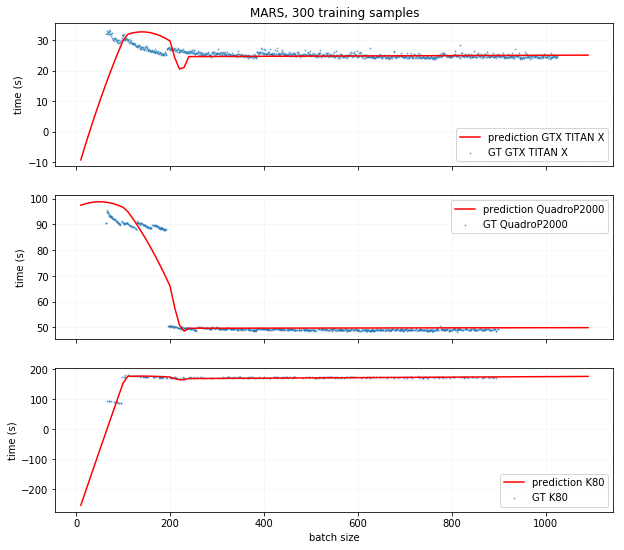

In [134]:
model = Earth(max_degree=2,max_terms=None,penalty=4,endspan=2)
model.fit(X_train,Y_train)
H_test = model.predict(X_test)
MSE_test = mean_squared_error(Y_test, H_test)
print "MST_test=",MSE_test
H_train = model.predict(X_train)
mean_squared_error(Y_train, H_train)
plotPredictions(model,"MARS, "+str(train_size)+" training samples")

In [156]:
print model._feature_importances_dict
model.summary_feature_importances()

{}


''